# <font color="blue">Project 2: DoppelGanger Find your Celebrity Look-Alike </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

### <font color="green">Your Task</font>
In this project, we will build a Fun Application - We will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, we will give you images of two persons and a celebrity dataset. Your task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

Given below is the Expected Output. 

### <font color="green">Expected Output</font>

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-selena.jpg)

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-amitabh.jpg)


By now, you should be able to discern what the problem is, and how you are going to solve it. You simply need a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. That's enough Hint!

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, we have curated a small dataset for this experiment.

We will use a subset of the Query set of the Celebrity Together Dataset in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset we have created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. We have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


## <font color="blue">Marks Distribution </font>
1. **Implementation - 70 Marks**
1. **Video Explanation - 30 marks**

#### <font color="red">Note that you are free to use any other dataset if you have the resources of space and compute to handle the large datasets.</font>


In [1]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

#### <font color="red">You are free to use other face recognition models as well. </font>

In [3]:
# Download dlib models
# Landmark model
# !wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
# !wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
# !bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

## <font color="blue">Explore Data </font>
In this section, we provide sample code of how to load the images and use the label mapping for your reference. This should help you get started with handling images and finding the embeddings.

In [67]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


'unzip' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

In [29]:
print(labelMap)

{'n00000001': 'A.J. Buckley', 'n00000002': 'A.R. Rahman', 'n00000003': 'Aamir Khan', 'n00000004': 'Aaron Staton', 'n00000005': 'Aaron Tveit', 'n00000006': 'Aaron Yoo', 'n00000007': 'Abbie Cornish', 'n00000008': 'Abel Ferrara', 'n00000009': 'A P J Abdul Kalam', 'n00000010': 'Abigail Breslin', 'n00000011': 'Abigail Klein', 'n00000012': 'Abigail Spencer', 'n00000013': 'Abraham Benrubi', 'n00000014': 'Adam Baldwin', 'n00000015': 'Adam Beach', 'n00000016': 'Adam Brody', 'n00000017': 'Adam Buxton', 'n00000018': 'Adam Copeland', 'n00000019': 'Adam Driver', 'n00000020': 'Adam G. Sevani', 'n00000021': 'Adam Garcia', 'n00000022': 'Adam Godley', 'n00000023': 'Adam Goldberg', 'n00000024': 'Adam Gregory', 'n00000025': 'Adam Hicks', 'n00000026': 'Adam Lambert', 'n00000027': 'Adam Levine', 'n00000028': 'Adam Rodriguez', 'n00000029': 'Adelaide Clemens', 'n00000030': 'Adelaide Kane', 'n00000031': 'Adina Porter', 'n00000032': 'Aditya Roy Kapoor', 'n00000033': 'Adrian Grenier', 'n00000034': 'Adrian Paul'

n00000914
<class 'str'>


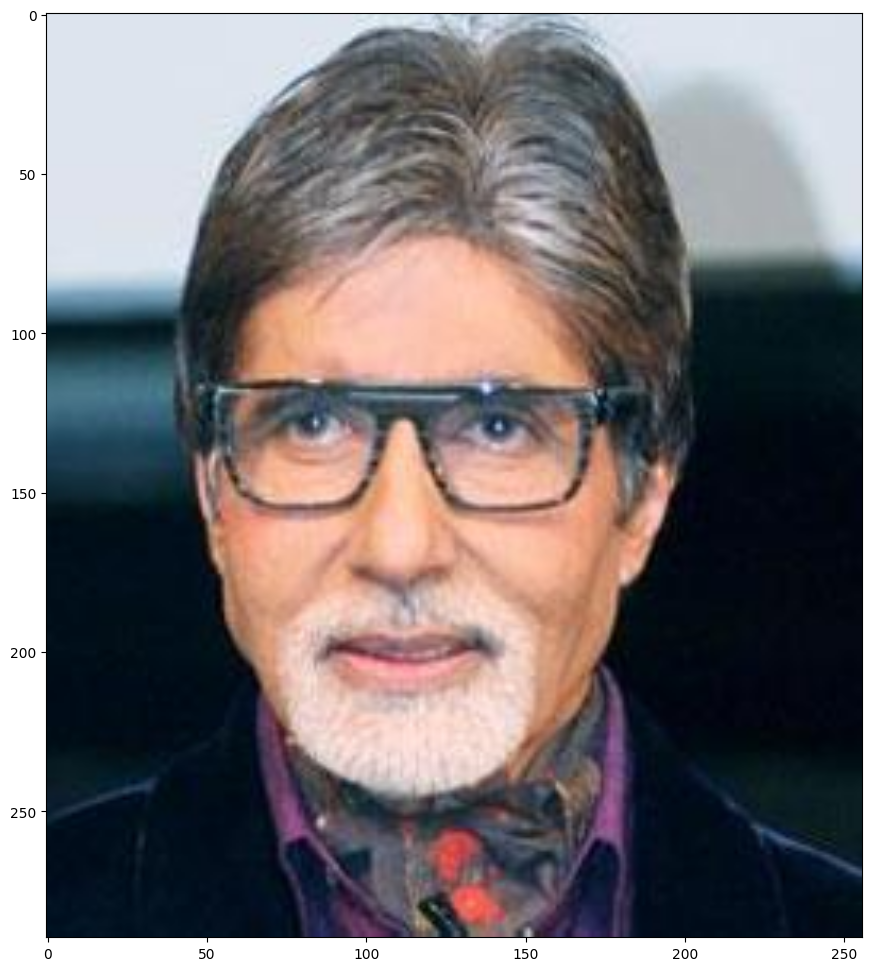

File path = celeb_mini\n00000102\n00000102_00000068.JPEG
Celeb Name: Amitabh Bachchan


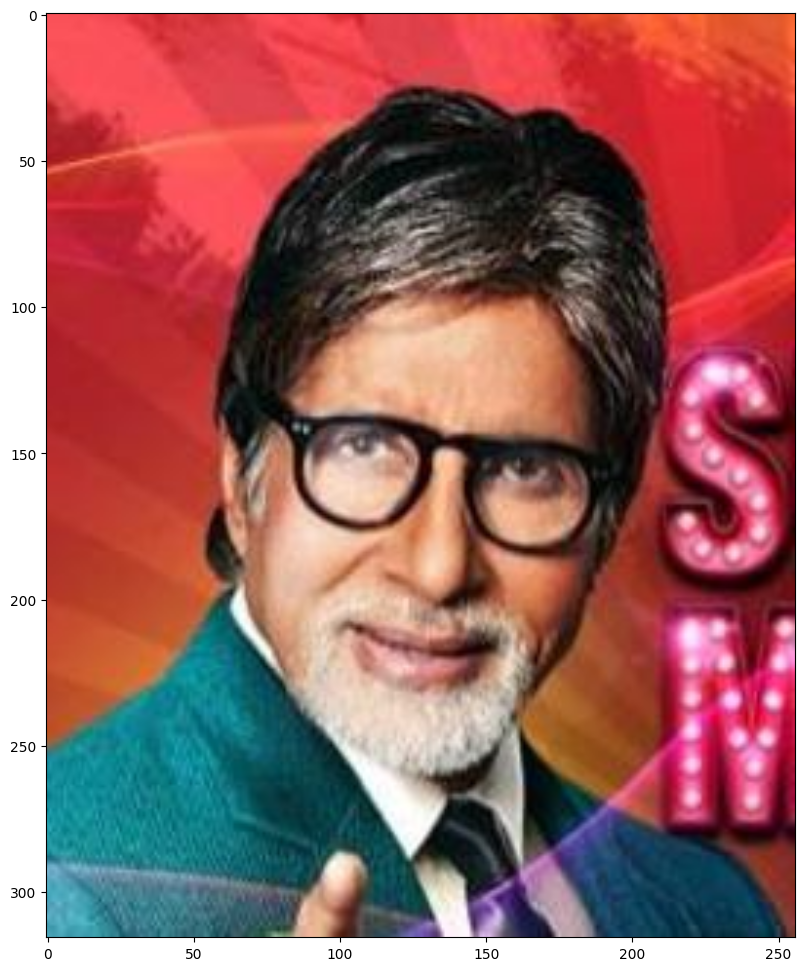

File path = celeb_mini\n00000102\n00000102_00000434.JPEG
Celeb Name: Amitabh Bachchan


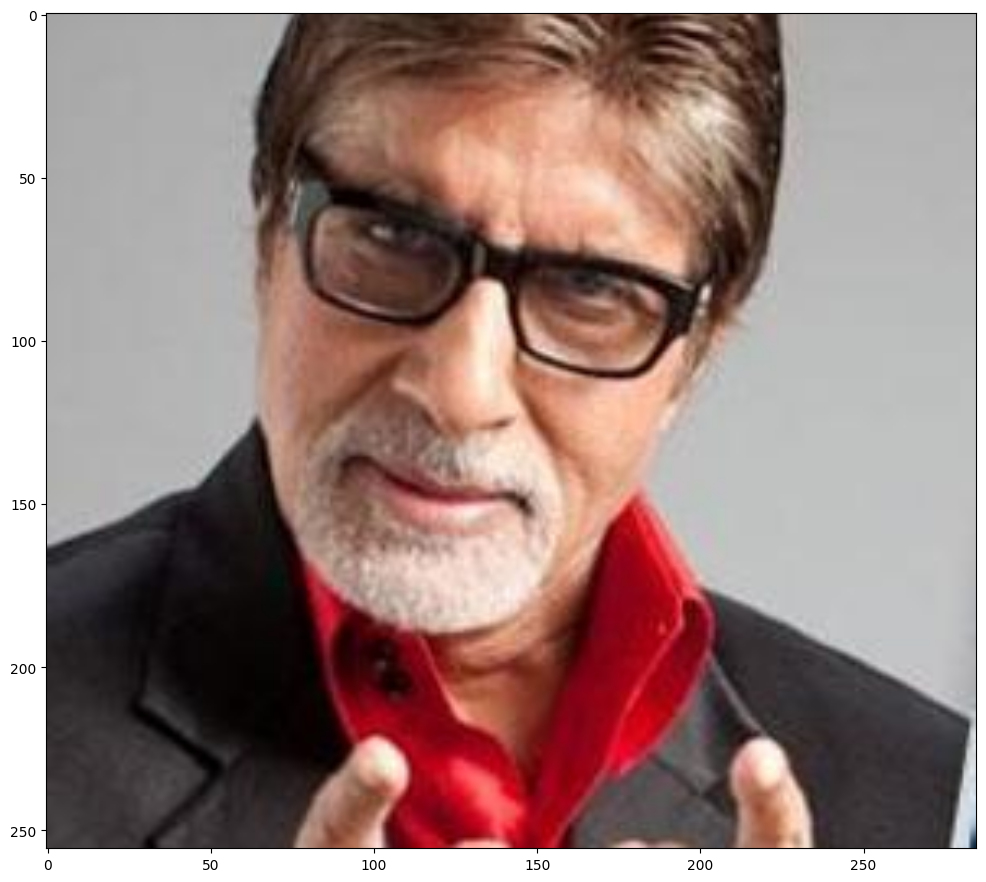

File path = celeb_mini\n00000102\n00000102_00000510.JPEG
Celeb Name: Amitabh Bachchan


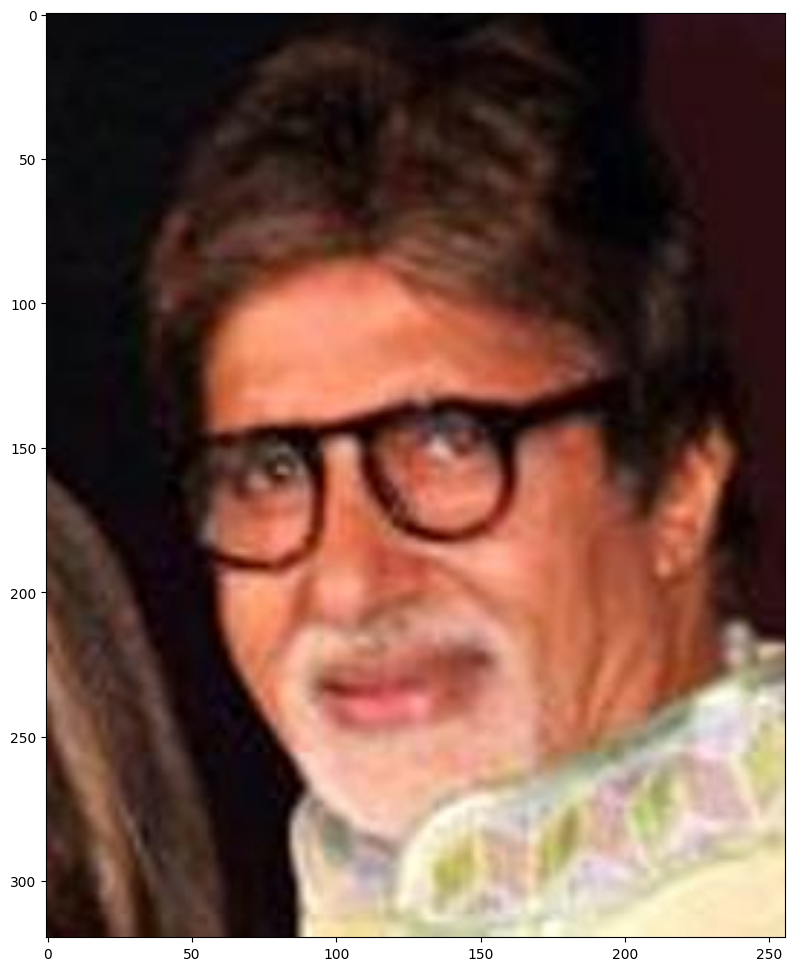

File path = celeb_mini\n00000102\n00000102_00000547.JPEG
Celeb Name: Amitabh Bachchan


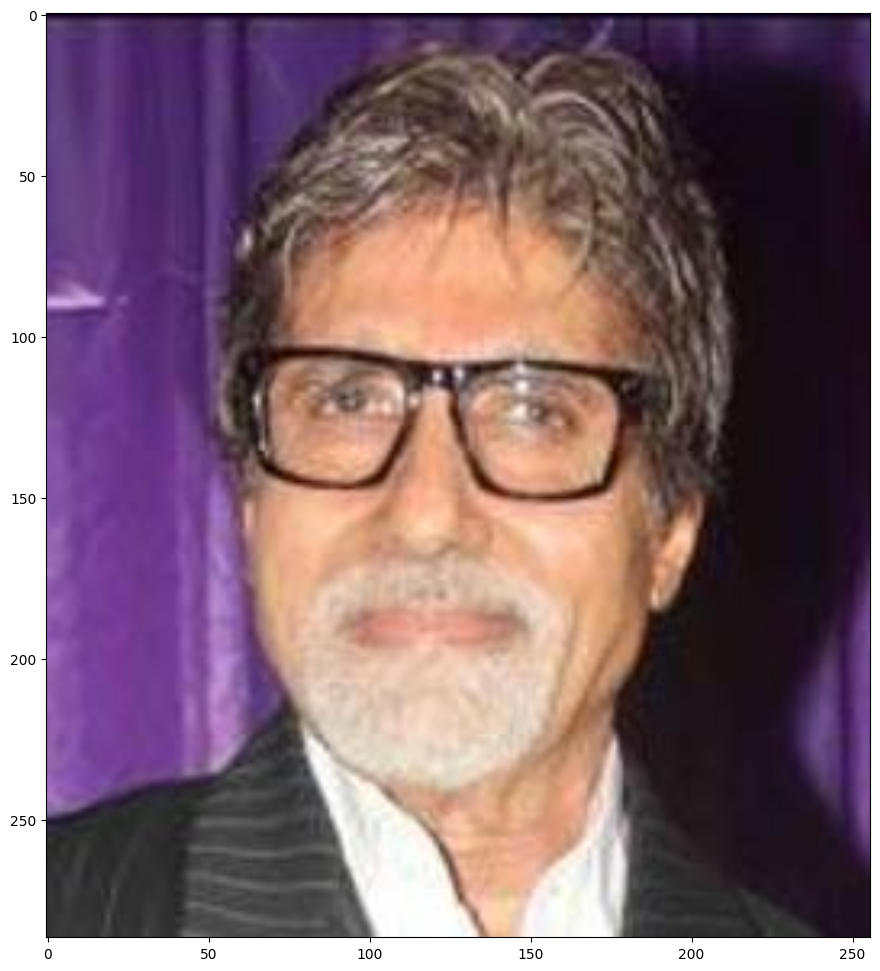

File path = celeb_mini\n00000102\n00000102_00000588.JPEG
Celeb Name: Amitabh Bachchan


In [30]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)
print(random_folder)
print(type(random_folder))
random_folder = 'n00000102'
# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

## <font color="blue">TODO</font>
You have to write the code for enrollment and testing to get the desired output as shown in the intro section.

**You can take help from the code we had provided in week 4 material.**

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [31]:
# Path to landmarks and face recognition model files
DATA_PATH = "C:/Users/Acer/workspace/OpenCV-DLPT 2024/week4-python/week4-python/data/"
PREDICTOR_PATH = DATA_PATH + 'models/shape_predictor_68_face_landmarks.dat'
FACE_RECOGNITION_MODEL_PATH = DATA_PATH + 'models/dlib_face_recognition_resnet_model_v1.dat'

# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(PREDICTOR_PATH)
faceRecognizer = dlib.face_recognition_model_v1(FACE_RECOGNITION_MODEL_PATH)

In [33]:
#YOUR CODE HERE

# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
# random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]
index = {}
i = 0
faceDescriptors = None
# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))
# index = []
# Read each image and display along with the filename and celeb name
for subfolder in subfolders:
    # for file in imagefiles:
    for file in os.listdir(os.path.join(faceDatasetFolder, subfolder)):
    #     Get full path of each image file
        fullPath = os.path.join(faceDatasetFolder,subfolder,file)
        # print(fullPath)
        img = cv2.imread(fullPath)

    # detect faces in image
        faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # print("{} Face(s) found".format(len(faces)))
        # Now process each face we found
        for k, face in enumerate(faces):

            # Find facial landmarks for each detected face
            shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

            # convert landmarks from Dlib's format to list of (x, y) points
            # landmarks = [(p.x, p.y) for p in shape.parts()]

            # Compute face descriptor using neural network defined in Dlib.
            # It is a 128D vector that describes the face in img identified by shape.
            faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

            # Convert face descriptor from Dlib's format to list, then a NumPy array
            faceDescriptorList = [x for x in faceDescriptor]
            faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
            faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

            # Stack face descriptors (1x128) for each face in images, as rows
            if faceDescriptors is None:
                faceDescriptors = faceDescriptorNdarray
            else:
                faceDescriptors = np.concatenate((faceDescriptors, faceDescriptorNdarray), axis=0)

            # save the label for this face in index. We will use it later to identify
            # person name corresponding to face descriptors stored in NumPy Array
            # print(fullPath)
            index[i] = fullPath
            i = i+ 1
            print(i)
            # if(i==10):
            #     break


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [34]:
print(index)

{0: 'celeb_mini\\n00000001\\n00000001_00000263.JPEG', 1: 'celeb_mini\\n00000001\\n00000001_00000405.JPEG', 2: 'celeb_mini\\n00000001\\n00000001_00000412.JPEG', 3: 'celeb_mini\\n00000001\\n00000001_00000583.JPEG', 4: 'celeb_mini\\n00000001\\n00000001_00000900.JPEG', 5: 'celeb_mini\\n00000003\\n00000003_00000386.JPEG', 6: 'celeb_mini\\n00000003\\n00000003_00000488.JPEG', 7: 'celeb_mini\\n00000003\\n00000003_00000514.JPEG', 8: 'celeb_mini\\n00000003\\n00000003_00000670.JPEG', 9: 'celeb_mini\\n00000003\\n00000003_00000922.JPEG', 10: 'celeb_mini\\n00000004\\n00000004_00000017.JPEG', 11: 'celeb_mini\\n00000004\\n00000004_00000036.JPEG', 12: 'celeb_mini\\n00000004\\n00000004_00000098.JPEG', 13: 'celeb_mini\\n00000004\\n00000004_00000283.JPEG', 14: 'celeb_mini\\n00000004\\n00000004_00000597.JPEG', 15: 'celeb_mini\\n00000006\\n00000006_00000079.JPEG', 16: 'celeb_mini\\n00000006\\n00000006_00000254.JPEG', 17: 'celeb_mini\\n00000006\\n00000006_00000262.JPEG', 18: 'celeb_mini\\n00000006\\n00000006

## <font color="red">2. Testing</font>
Once you have enrolled the celebs, you should be able to use them to find the closest celeb to the given test image using minimum distance rule.

You need to find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image. Partial code is given.

In [35]:
import _pickle as cPickle

In [37]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

In [38]:
THRESHOLD = 0.57

In [39]:
# Write descriors and index to disk
np.save('descriptors.npy', faceDescriptors)
# index has image paths in same order as descriptors in faceDescriptors
with open('index.pkl', 'wb') as f:
  cPickle.dump(index, f)

In [40]:
# Path to landmarks and face recognition model files
PREDICTOR_PATH = DATA_PATH + 'models/shape_predictor_68_face_landmarks.dat'
FACE_RECOGNITION_MODEL_PATH = DATA_PATH + 'models/dlib_face_recognition_resnet_model_v1.dat'

# THRESHOLD = 0.6

# Initialize face detector, 
# facial landmarks detector and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(PREDICTOR_PATH)
faceRecognizer = dlib.face_recognition_model_v1(FACE_RECOGNITION_MODEL_PATH)

# load descriptors and index file generated during enrollment
index = np.load('index.pkl', allow_pickle=True)
faceDescriptorsEnrolled = np.load('descriptors.npy')

In [41]:
print(index)

{0: 'celeb_mini\\n00000001\\n00000001_00000263.JPEG', 1: 'celeb_mini\\n00000001\\n00000001_00000405.JPEG', 2: 'celeb_mini\\n00000001\\n00000001_00000412.JPEG', 3: 'celeb_mini\\n00000001\\n00000001_00000583.JPEG', 4: 'celeb_mini\\n00000001\\n00000001_00000900.JPEG', 5: 'celeb_mini\\n00000003\\n00000003_00000386.JPEG', 6: 'celeb_mini\\n00000003\\n00000003_00000488.JPEG', 7: 'celeb_mini\\n00000003\\n00000003_00000514.JPEG', 8: 'celeb_mini\\n00000003\\n00000003_00000670.JPEG', 9: 'celeb_mini\\n00000003\\n00000003_00000922.JPEG', 10: 'celeb_mini\\n00000004\\n00000004_00000017.JPEG', 11: 'celeb_mini\\n00000004\\n00000004_00000036.JPEG', 12: 'celeb_mini\\n00000004\\n00000004_00000098.JPEG', 13: 'celeb_mini\\n00000004\\n00000004_00000283.JPEG', 14: 'celeb_mini\\n00000004\\n00000004_00000597.JPEG', 15: 'celeb_mini\\n00000006\\n00000006_00000079.JPEG', 16: 'celeb_mini\\n00000006\\n00000006_00000254.JPEG', 17: 'celeb_mini\\n00000006\\n00000006_00000262.JPEG', 18: 'celeb_mini\\n00000006\\n00000006

2948
celeb_mini\n00001270\n00001270_00000731.JPEG 0.5610159529240807
time taken = 0.855 seconds
Karan Brar 0.5610


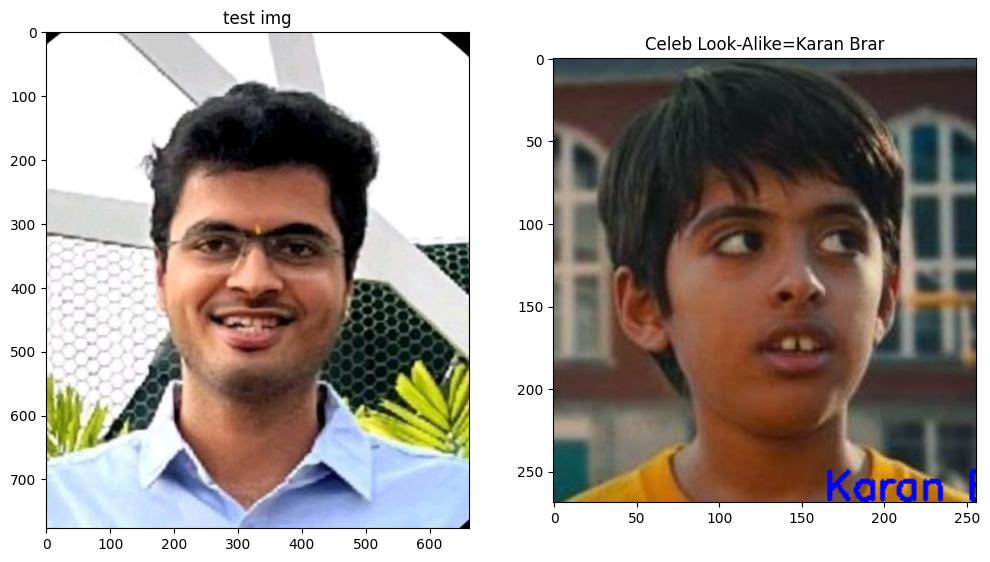

253
celeb_mini\n00000102\n00000102_00000068.JPEG 0.42035206129056896
time taken = 0.577 seconds
Amitabh Bachchan 0.4204


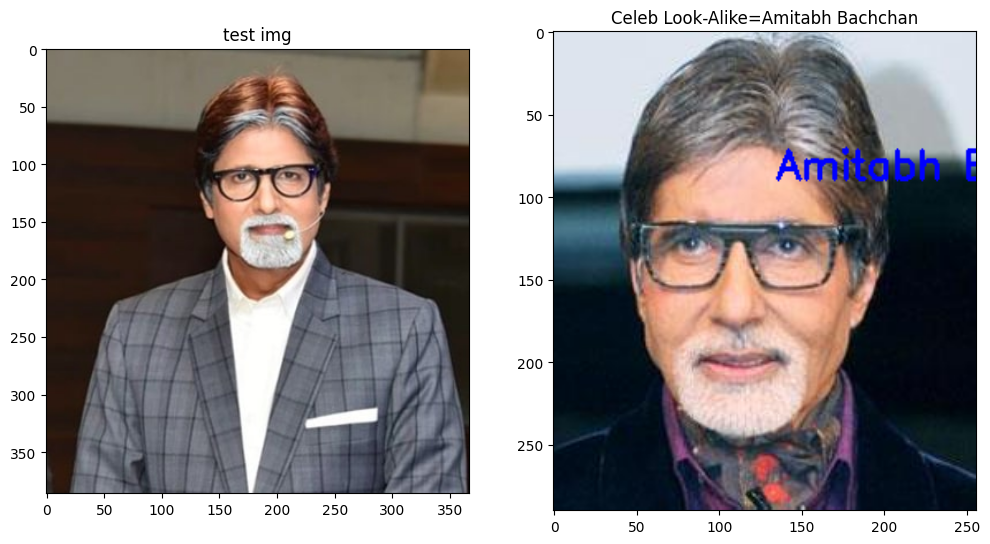

4970
celeb_mini\n00002238\n00002238_00000156.JPEG 0.5432983684823053
time taken = 0.584 seconds
Selena 0.5433


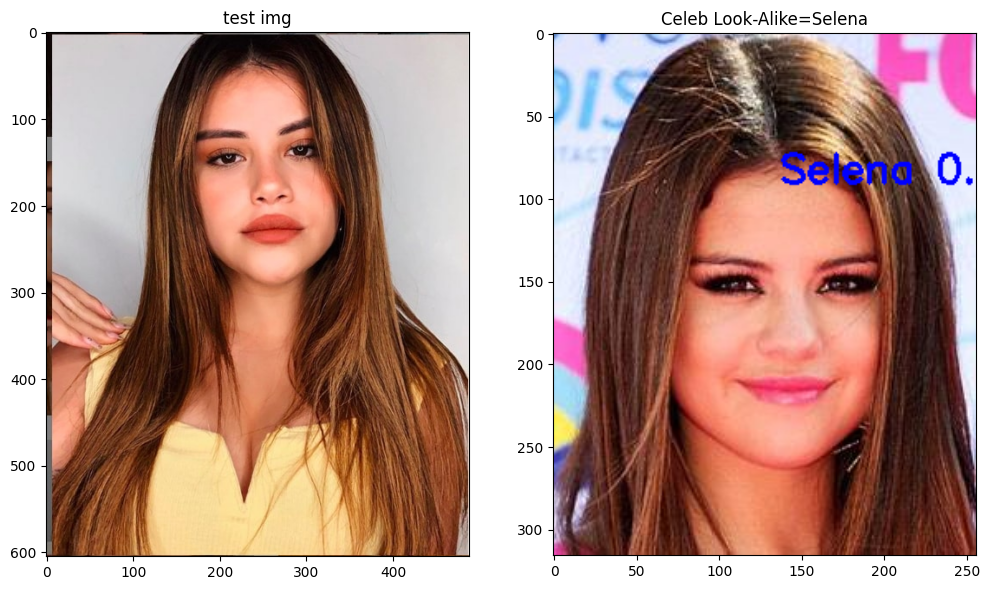

In [43]:
# read image
testImages = glob.glob('test-images/*.jpg')
celeb_name = ""
for test in testImages:
    im = cv2.imread(test)
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    #####################
    #  YOUR CODE HERE
    t = time.time()

    # detect faces in image
    faces = faceDetector(imDlib)

    # Now process each face we found
    for face in faces:

    # Find facial landmarks for each detected face
        shape = shapePredictor(imDlib, face)

        # find coordinates of face rectangle
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        # Compute face descriptor using neural network defined in Dlib
        # using facial landmark shape
        faceDescriptor = faceRecognizer.compute_face_descriptor(im, shape)

        # Convert face descriptor from Dlib's format to list, then a NumPy array
        faceDescriptorList = [m for m in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

        # Calculate Euclidean distances between face descriptor calculated on face dectected
        # in current frame with all the face descriptors we calculated while enrolling faces
        distances = np.linalg.norm(faceDescriptorsEnrolled - faceDescriptorNdarray, axis=1) #Axis=1 Row-Wise Operation
        # Calculate minimum distance and index of this face
        argmin = np.argmin(distances)  # index
        minDistance = distances[argmin]  # minimum distance
        
        # Dlib specifies that in general, if two face descriptor vectors have a Euclidean
        # distance between them less than 0.6 then they are from the same
        # person, otherwise they are from different people.

        # This threshold will vary depending upon number of images enrolled
        # and various variations (illuminaton, camera quality) between
        # enrolled images and query image
        # We are using a threshold of 0.5

        # If minimum distance if less than threshold
        # find the name of person from index
        # else the person in query image is unknown
        if minDistance <= THRESHOLD:
            print(argmin)
            label = index[argmin]
            parts = label.split("\\")
            celeb_name = labelMap[parts[1]]
            # print(parts)
        else:
            label = 'unknown'
        print(label , minDistance)
        print("time taken = {:.3f} seconds".format(time.time() - t))

        # Draw a rectangle for detected face
        # cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255))

        # Draw circle for face recognition
        # center = (int((x1 + x2)/2.0), int((y1 + y2)/2.0))
        # radius = int((y2-y1)/2.0)
        # color = (0, 255, 0)
        # cv2.circle(im, center, radius, color, thickness=1, lineType=8, shift=0)

        # Write test on image specifying identified person and minimum distance
        
        

        # celeb_name = ""
        ####################
        
        plt.subplot(121)
        plt.imshow(imDlib)
        plt.title("test img")
        
        #TODO - display celeb image which looks like the test image instead of the black image. 
        if(label != 'unknown'):
            org = (int(x1), int(y1))  # bottom left corner of text string
            
            im2 = cv2.imread(label)
            font_face = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.8
            text_color = (255, 0, 0)
            printLabel = '{} {:0.4f}'.format(celeb_name, minDistance)
            print(printLabel)
            cv2.putText(im2, printLabel, org, font_face, font_scale, text_color, thickness=2)
            plt.subplot(122)
            plt.imshow(im2[:, :, ::-1])
            plt.title("Celeb Look-Alike={}".format(celeb_name))
            plt.show()